In [1]:
import environmentv6 as e
import mdptoolbox
import matplotlib.pyplot as plt
import numpy as np
import progressbar as pb
import scipy.sparse as ss
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=ss.SparseEfficiencyWarning)

In [17]:
# params
alpha = 0.4
T = 8
state_count = (T+1) * (T+1)
epsilon = 10e-5

# game
action_count = 3
adopt = 0; override = 1; mine = 2

# mapping utils
state_mapping = {}
states = []
count = 0
for a in range(T+1):
    for h in range(T+1):
            state_mapping[(a, h)] = count
            states.append((a, h))
            count += 1

# initialize matrices
transitions = []; rewards = []
for _ in range(action_count):
    transitions.append(ss.csr_matrix(np.zeros(shape=(state_count, state_count))))
    rewards.append(ss.csr_matrix(np.zeros(shape=(state_count, state_count))))

In [18]:
mining_cost = 0.52

# populate matrices
for state_index in range(state_count):
    a, h = states[state_index]

    # adopt transitions
    transitions[adopt][state_index, state_mapping[0, 0]] = 1

    # override
    if a > h:
        transitions[override][state_index, state_mapping[a-h-1, 0]] = 1
        rewards[override][state_index, state_mapping[a-h-1, 0]] = h + 1
    else:
        transitions[override][state_index, 0] = 1
        rewards[override][state_index, 0] = -10000

    # mine transitions
    if (a < T) and (h < T):
        transitions[mine][state_index, state_mapping[a+1, h]] = alpha
        transitions[mine][state_index, state_mapping[a, h+1]] = (1 - alpha) 
        rewards[mine][state_index, state_mapping[a+1, h]] = -1 * alpha * mining_cost
        rewards[mine][state_index, state_mapping[a, h+1]] = -1 * alpha * mining_cost
#         transitions[mine][state_index, state_mapping[a, h]] = 1 - (1 - alpha) * difficulty  - alpha * difficulty
#         reward[mine][state_index, state_mapping[a, h]] = -1 * alpha * mining_cost
        
    else:
        transitions[mine][state_index, 0] = 1
        rewards[mine][state_index, 0] = -10000

In [19]:
rvi = mdptoolbox.mdp.RelativeValueIteration(transitions, rewards, epsilon/8)
rvi.run()
policy = rvi.policy

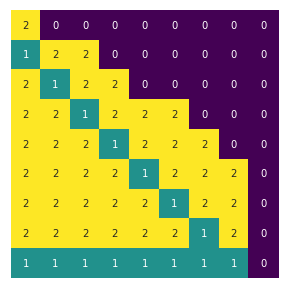

In [20]:
f, ax = plt.subplots(figsize=(6,6))
ax.imshow(np.reshape(policy, (9,9)))
ax = sns.heatmap(np.reshape(policy, (9,9)), annot=True, cmap='viridis')
cb = ax.collections[-1].colorbar   
cb.remove()
plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
sm1_policy = np.asarray([
[2, 0, 9, 9, 9, 9, 9, 9, 9],
[2, 0, 9, 9, 9, 9, 9, 9, 9],
[2, 1, 0, 9, 9, 9, 9, 9, 9], 
[2, 2, 1, 0, 9, 9, 9, 9, 9],
[2, 2, 2, 1, 0, 9, 9, 9, 9],
[2, 2, 2, 2, 1, 0, 9, 9, 9],
[2, 2, 2, 2, 2, 1, 0, 9, 9],
[2, 2, 2, 2, 2, 2, 1, 0, 9],
[1, 1, 1, 1, 1, 1, 1, 1, 0]
])

honest_policy = np.asarray([
[2, 0, 9, 9, 9, 9, 9, 9, 9],
[1, 9, 9, 9, 9, 9, 9, 9, 9],
[9, 9, 9, 9, 9, 9, 9, 9, 9], 
[9, 9, 9, 9, 9, 9, 9, 9, 9],
[9, 9, 9, 9, 9, 9, 9, 9, 9],
[9, 9, 9, 9, 9, 9, 9, 9, 9],
[9, 9, 9, 9, 9, 9, 9, 9, 9],
[9, 9, 9, 9, 9, 9, 9, 9, 9],
[9, 9, 9, 9, 9, 9, 9, 9, 9]
])

opt_policy = np.reshape(policy, (9,9))

In [22]:
def get_opt_policy(alpha, T, mining_cost):
    for state_index in range(state_count):
        a, h = states[state_index]

        # adopt transitions
        transitions[adopt][state_index, state_mapping[0, 0]] = 1

        # override
        if a > h:
            transitions[override][state_index, state_mapping[a-h-1, 0]] = 1
            rewards[override][state_index, state_mapping[a-h-1, 0]] = h + 1
        else:
            transitions[override][state_index, 0] = 1
            rewards[override][state_index, 0] = -10000

        # mine transitions
        if (a < T) and (h < T):
            transitions[mine][state_index, state_mapping[a+1, h]] = alpha
            transitions[mine][state_index, state_mapping[a, h+1]] = (1 - alpha) 
            rewards[mine][state_index, state_mapping[a+1, h]] = -1 * alpha * mining_cost
            rewards[mine][state_index, state_mapping[a, h+1]] = -1 * alpha * mining_cost        
        else:
            transitions[mine][state_index, 0] = 1
            rewards[mine][state_index, 0] = -10000
        
        rvi = mdptoolbox.mdp.RelativeValueIteration(transitions, rewards, epsilon/8)
        rvi.run()
        return np.reshape(rvi.policy, (T+1, T+1))

In [26]:
get_opt_policy(alpha=0.4, T=8, mining_cost=0.5)

array([[2, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 2, 2, 0, 0, 0, 0, 0, 0],
       [2, 1, 2, 2, 2, 0, 0, 0, 0],
       [2, 2, 1, 2, 2, 2, 0, 0, 0],
       [2, 2, 2, 1, 2, 2, 2, 0, 0],
       [2, 2, 2, 2, 1, 2, 2, 2, 0],
       [2, 2, 2, 2, 2, 1, 2, 2, 0],
       [2, 2, 2, 2, 2, 2, 1, 2, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0]])

In [15]:
# simulation
length = int(1e6)
alpha = 0.4
T = 8
mining_cost = 0.5
env = e.Environment(alpha, T, mining_cost)

# simulation
bar = pb.ProgressBar()
_ = env.reset()
current_reward = 0
for _ in bar(range(length)):
    a, h = env.current_state
    action = opt_policy[(a,h)]
    _, reward = env.takeAction(action)
    current_reward += reward

100% (1000000 of 1000000) |##############| Elapsed Time: 0:00:28 Time:  0:00:28


In [16]:
# opt
print(current_reward, current_reward / length)

101211.00000130651 0.10121100000130652


In [119]:
# sm1
print(current_reward, current_reward / length)

54266.60000058278 0.05426660000058278


In [12]:
# honest
print(current_reward, current_reward / length)

100698.00000089758 0.10069800000089758
